<a href="https://colab.research.google.com/github/carlachka/7605_TP1/blob/master/tp1_GMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real or Not? Disaster Tweets - EDA

In [0]:
# import the bilbiotecas
import pandas as pd
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib_venn import venn2

from scipy import stats
from collections import Counter

import nltk
nltk.download('punkt')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
from nltk.util import ngrams

## all reviews
# building of the bi-grams
#Counter(list(ngrams(reviews_without_stop_words, 2))).most_common(20)

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#https://drive.google.com/open?id=1VkZ0rnoUMvwbXR9t7z9OccNZAyty40v-

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id='1VkZ0rnoUMvwbXR9t7z9OccNZAyty40v-'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train.csv')


In [0]:
# Load the Data and take a quick look for train.csv
df = pd.read_csv('train.csv', encoding='latin-1')
df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


### Descripción de las columnas

##### falta breve descripción

**id** - identificador unico para cada  tweet  
**text** - el texto del tweet  
**location** - ubicación desde donde fue enviado (podría no estar)  
**keyword** - un keyword para el tweet  (podría faltar)  
**target** - en train.csv, indica si se trata de un desastre real  (1) o no (0)

In [0]:
display(df.sample(3))

,id,keyword,location,text,target
3138,4509,emergency,USA,Deals : http://t.co/ddhWoRI5w1 #37592 Temporar...,0
3022,4337,dust%20storm,Worldwide,New Mad Max Screenshots Show Off a Lovely Dust...,0
3696,5259,fatality,Honduras,Fatality ????,0


Teniendo un idea general sobre lo que trata el dataset, iremos más en profundidad con cada una de las 4 variables.

Tambien miramos brevemente el data frame test.csv para buscar relaciones con train.csv

In [0]:
id='1JbnfMMVuipDT_pQ1FYD2shLRkFAf14ov'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test.csv')

In [0]:
# https://drive.google.com/open?id=1JbnfMMVuipDT_pQ1FYD2shLRkFAf14ov
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [0]:
# # Rapida vista de test.csv
test_df = pd.read_csv('test.csv', encoding='latin-1')
test_df.tail()

,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÂÃÃ SAFETY FA...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


### Valores faltantes

In [0]:
df.shape

(7613, 5)

In [0]:
train_df=df.drop_duplicates(['keyword','text','location'], inplace=False)

In [0]:
train_df.shape

(7552, 5)

In [0]:
7613 - 7552

61

Al momento de quitar duplicados en la base de datos, comparamos cuantos registros se perdian considerando las variables keyword, text y location. En este caso se estarian eliminando 61 registros. Tambien analizamos cuantos registros se perderian si consideramos la variable target.

In [0]:
train2_df=df.drop_duplicates(['keyword','text','location','target'], inplace=False)

In [0]:
train2_df.shape

(7561, 5)

In [0]:
7613 - 7561

52

Al incluir la variable target, vemos que eliminariamos 52 registros duplicados. Esto quiere decir que hay tweets que son completamente iguales - no solo incluyendo su texto, tambien location y su keyword - , pero que hay veces en las que estan marcados como desastre (target = 1) y otras veces en las que estan marcados como no desastre (target = 0).

Consideramos que esta es una inconsistencia en la base de datos, que afectaria el objetivo de predecir si un cierto tweet es real o no en el futuro. Consecuentemente decidimos quedarnos con los registros unicos considerando las variables text keyword y location.

De esta forma, cuando vuelve a aparcer un registro que tiene el mismo text keyword y location, se elimina. Eliminamos 52 registros repetidos.

In [0]:
notnull_df = df[['keyword', 'location']].notnull().sum()
notnull_test_df =  test_df[['keyword', 'location']].notnull().sum()
notnull_df

keyword     7552
location    5080
dtype: int64

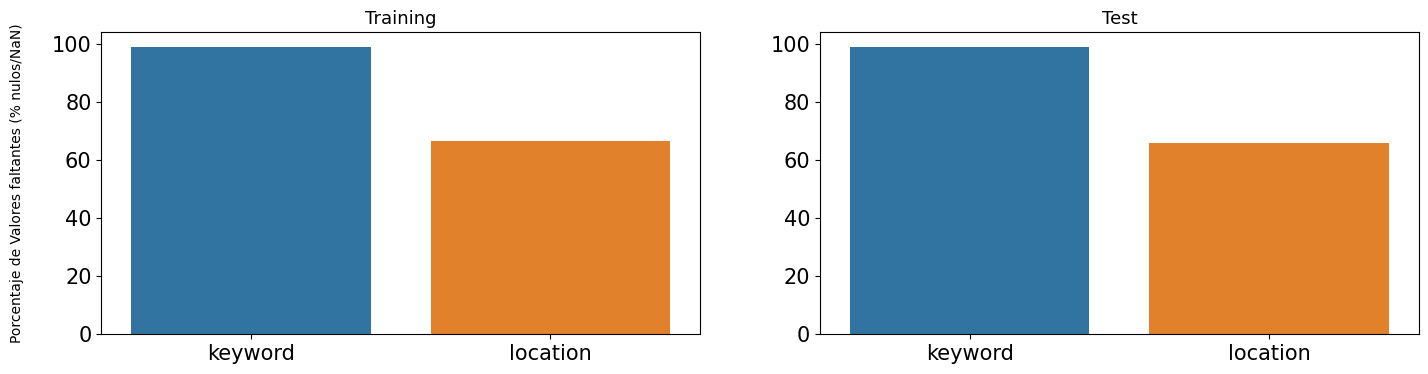

In [0]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=notnull_df.index, y=notnull_df/len(df)*100, ax=axes[0])
sns.barplot(x=notnull_test_df.index, y=notnull_test_df/len(test_df)*100, ax=axes[1])

axes[0].set_ylabel('Porcentaje de Valores faltantes (% nulos/NaN)', size=10, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training', fontsize=13)
axes[1].set_title('Test', fontsize=13)

import matplotlib.pyplot as plt

plt.show()


###Duplicados

- Observamos que hay registros de tweets que coinciden en el campo "text", y asumimos que se trata de tweets duplicados.
- Obtengo agrupados los tweets que tienen coincidencia en el campo 'text', y calculamos la media de targuet y cantidad de coincidencias por grupo.

In [0]:
bool_duplicated =  df['text'].duplicated(keep = False)
df_duplicates = df[bool_duplicated].groupby('text').target.agg(['mean', 'count']).rename(columns={'mean':'target_mean','count':'target_count'}).sort_values(by='target_mean', ascending=False)
df_duplicates

,target_mean,target_count
text,,
Swansea ÂÃÃ·plot hijack transfer move for Southampton target Virgil van DijkÂÃÂª http://t.co/PVmr38LnvA,1.0,2
abcnews - Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern... http://t.co/mg5eAJElul,1.0,2
Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM,1.0,3
Burning buildings? Media outrage? http://t.co/pHixZnv1YN,1.0,2
RT AbbsWinston: #Zionist #Terrorist kidnapped 15 #Palestinians in overnight terror on Palestinian Villages ÂÃ_ http://t.co/J5mKcbKcov,1.0,2
...,...,...
@TinyJecht Are you another Stand-user? If you are I will have to detonate you with my Killer Queen.,0.0,3
320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÂÃ_ http://t.co/zEVakJaPcz,0.0,2
that exploded &amp; brought about the\nbeginning of universe matches what's\nmentioned in the versethe heaven and Earth\n(thus the universe),0.0,2


- Observamos que en cada grupo hay discrepancia de tagueo, por lo cual decidimos quedarnos con un solo tweet por grupo, asumiendo un targuet calculado en funcion de una logica de votación (mayoria de targuet del grupo)

In [0]:
df_duplicates['assumed_target'] = df_duplicates['target_mean'].apply(lambda x: int(1) if x>0.5 else int(0))
df_duplicates

,target_mean,target_count,assumed_target
text,,,
Swansea ÂÃÃ·plot hijack transfer move for Southampton target Virgil van DijkÂÃÂª http://t.co/PVmr38LnvA,1.0,2,1
abcnews - Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern... http://t.co/mg5eAJElul,1.0,2,1
Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM,1.0,3,1
Burning buildings? Media outrage? http://t.co/pHixZnv1YN,1.0,2,1
RT AbbsWinston: #Zionist #Terrorist kidnapped 15 #Palestinians in overnight terror on Palestinian Villages ÂÃ_ http://t.co/J5mKcbKcov,1.0,2,1
...,...,...,...
@TinyJecht Are you another Stand-user? If you are I will have to detonate you with my Killer Queen.,0.0,3,0
320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÂÃ_ http://t.co/zEVakJaPcz,0.0,2,0
that exploded &amp; brought about the\nbeginning of universe matches what's\nmentioned in the versethe heaven and Earth\n(thus the universe),0.0,2,0


- Nos quedamos con el primer tweet de cada grupo de duplicados (dropeando el resto), y les reasignamos el target asumido en el punto anterior

In [0]:
duplicatedExFirst =  df['text'].duplicated(keep = 'first')
firstDuplicate = bool_duplicated ^ duplicatedExFirst 

df[firstDuplicate]['target'] = df_duplicates['assumed_target'] 
df.drop_duplicates(['text'], inplace=True, keep='first')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7503 non-null   int64 
 1   keyword   7447 non-null   object
 2   location  5021 non-null   object
 3   text      7503 non-null   object
 4   target    7503 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 351.7+ KB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Variables

#### keyword

Se trata de  221 palabras clave. Aquí las 20 más repetidas.


Text(0.5, 1.0, 'Frecuencia de Keywords en Train')

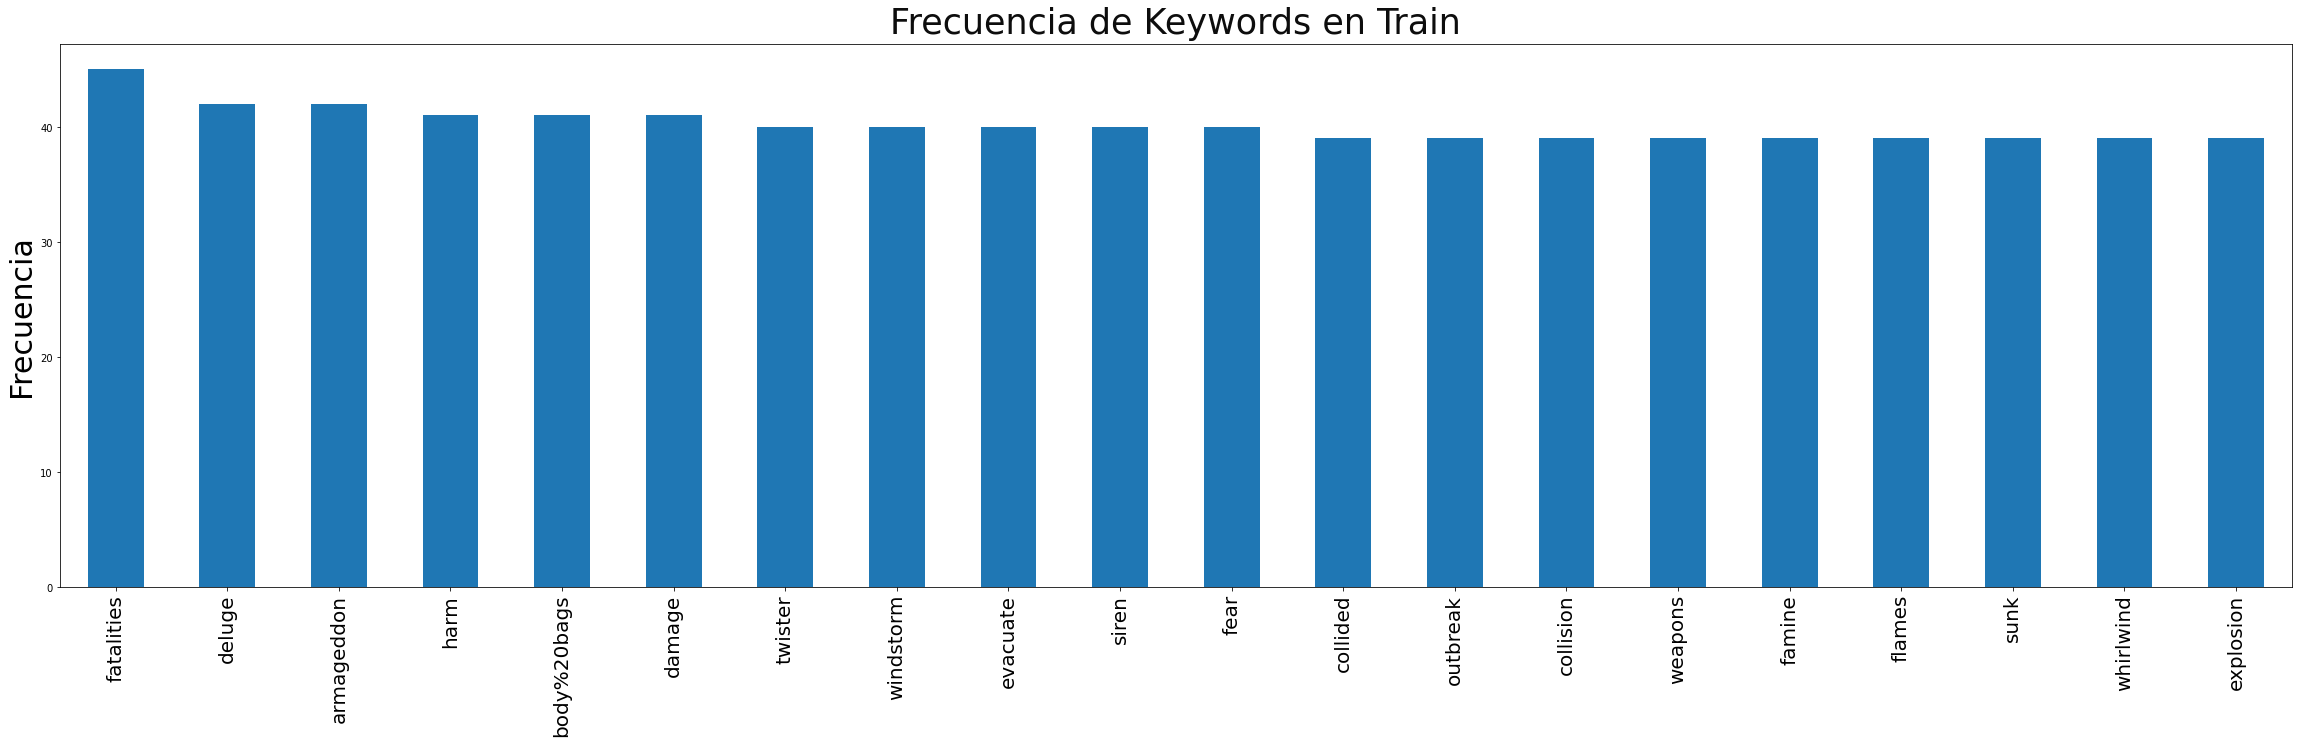

In [0]:
# histograma para identificar alguna/as palabra clave particular
## plt configs
plt.figure(figsize=[40,10])
plt.xticks(fontsize=20, rotation=70)

fig = df['keyword'].value_counts().head(20).plot(kind='bar')
print('Se trata de ', df['keyword'].nunique(), 'palabras clave. Aquí las 20 más repetidas.')
fig.set_ylabel('Frecuencia', size=30)
plt.title('Frecuencia de Keywords en Train', color=(0.05,0.05,0.05), pad=10, fontsize=35)

Por el momento, no exige más análisis como variable en sí en el data frame train, ya que es una palabra clave asignada. Más adelante estudiaremos si exige alguna relación con otra variable.

Lo que si podemos ver es si estas keywords tambien se encuentran en el data frame test.

In [0]:
id='1JbnfMMVuipDT_pQ1FYD2shLRkFAf14ov'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test.csv')

In [0]:
# https://drive.google.com/open?id=1JbnfMMVuipDT_pQ1FYD2shLRkFAf14ov

In [0]:
# # Rapida vista de test.csv
test_df = pd.read_csv('test.csv', encoding='latin-1')
test_df.tail()

,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÂÃÃ SAFETY FA...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


Se trata de  221 palabras clave. Aquí las 20 más repetidas.


Text(0.5, 1.0, 'Frecuencia de Keywords en Test')

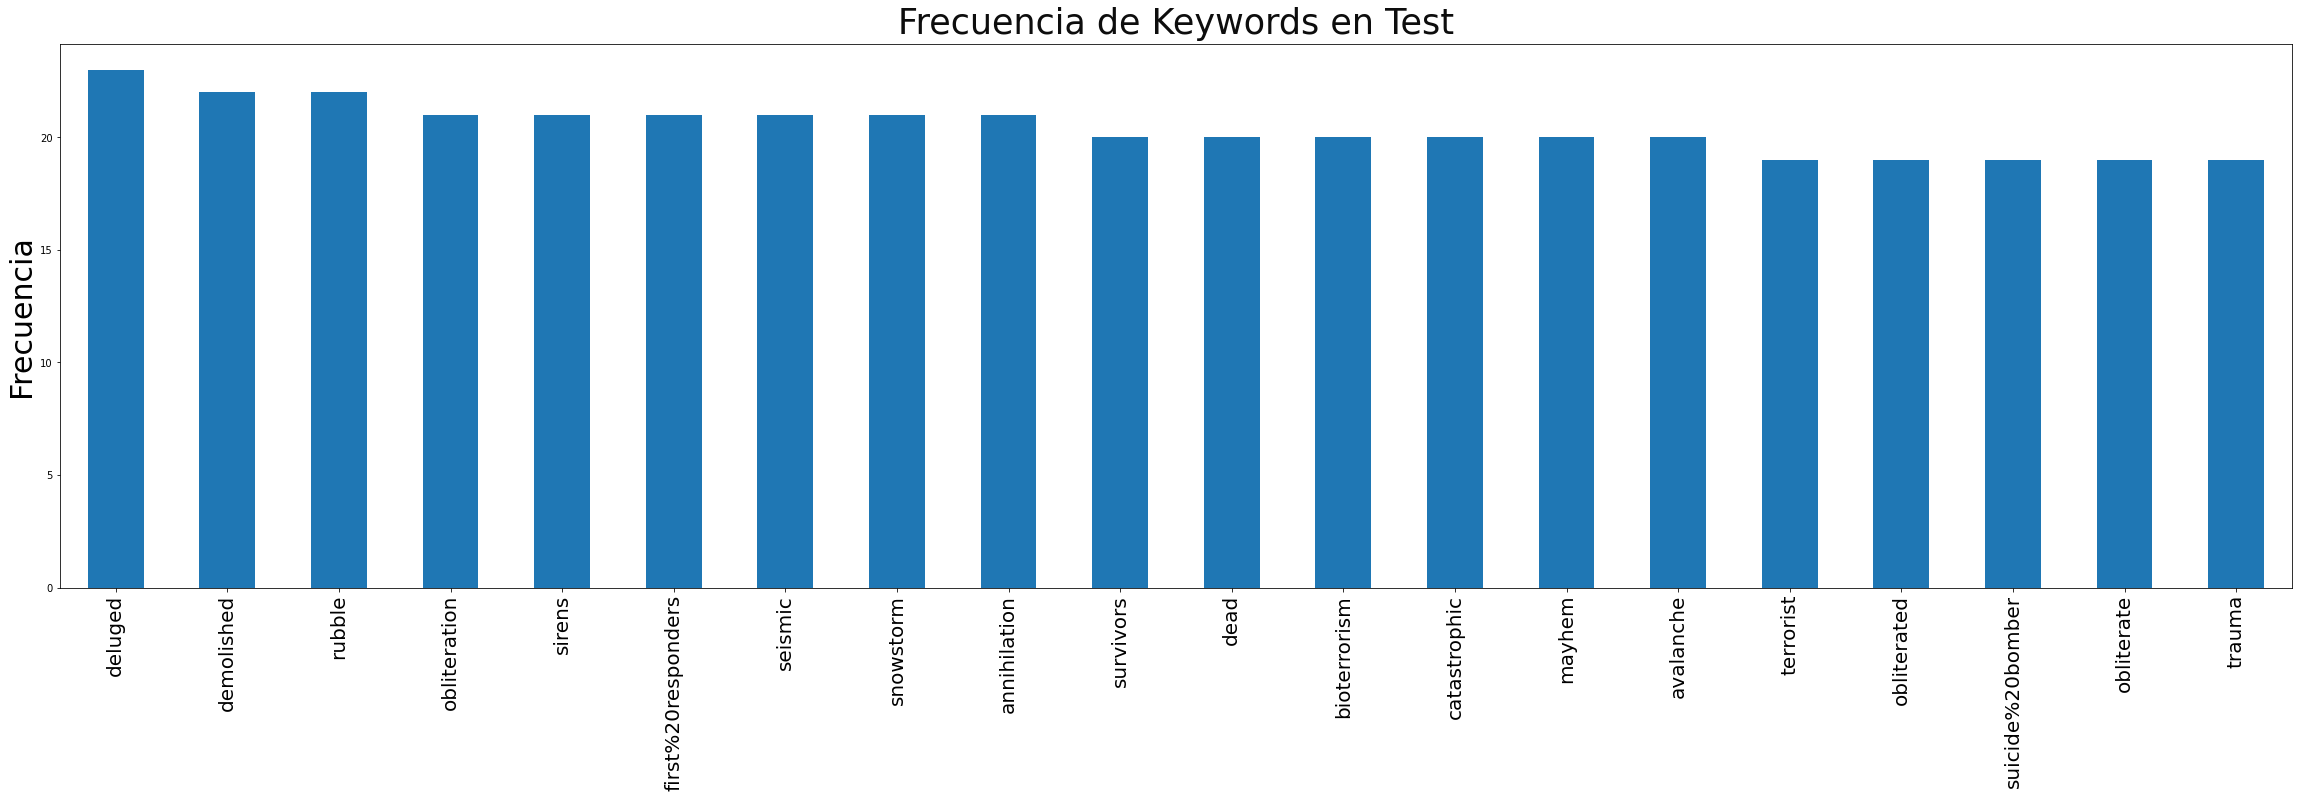

In [0]:
plt.figure(figsize=[40,10])
plt.xticks(fontsize=20, rotation=70)

fig = test_df['keyword'].value_counts().head(20).plot(kind='bar')
print('Se trata de ', test_df['keyword'].nunique(), 'palabras clave. Aquí las 20 más repetidas.')
fig.set_ylabel('Frecuencia', size=30)
plt.title('Frecuencia de Keywords en Test', color=(0.05,0.05,0.05), pad=10, fontsize=35)

Pareceria que las 221 keywords que se encuentran en el data frame train, tambien se encuentran en el test data frame. Consecuentemente, la variable keyword podria ser util al momento de predecir si los tweets son reales o no.

#####Word Cloud de Keywords simples y Keywords "completos"

In [0]:
SingleKeywords = df['keyword'].str.split('%20', expand=True)
SingleKeywords['target_kw0'] = df['target']
SingleKeywords['target_kw1'] = df['target']
SingleKeywords['target_kw2'] = df['target']
SKW_stats = pd.DataFrame([])
SKW_stats['SingleKeword'] = SingleKeywords[[0, 1, 2]].values.flatten()
SKW_stats['target'] = SingleKeywords[['target_kw0', 'target_kw1', 'target_kw2']].values.flatten()
SKW_stats.dropna(inplace=True)
SKW_stats = SKW_stats.groupby(['SingleKeword']).agg(['mean', 'count']).sort_values(by=('target', 'mean'), ascending=True)
SKW_stats

target      
                  mean count
SingleKeword                
aftershock    0.000000    34
bags          0.024390    41
ruin          0.027027    37
blazing       0.029412    34
bag           0.030303    33
...                ...   ...
typhoon       0.973684    38
outbreak      0.975000    40
derailment    1.000000    39
debris        1.000000    37
wreckage      1.000000    39

[229 rows x 2 columns]

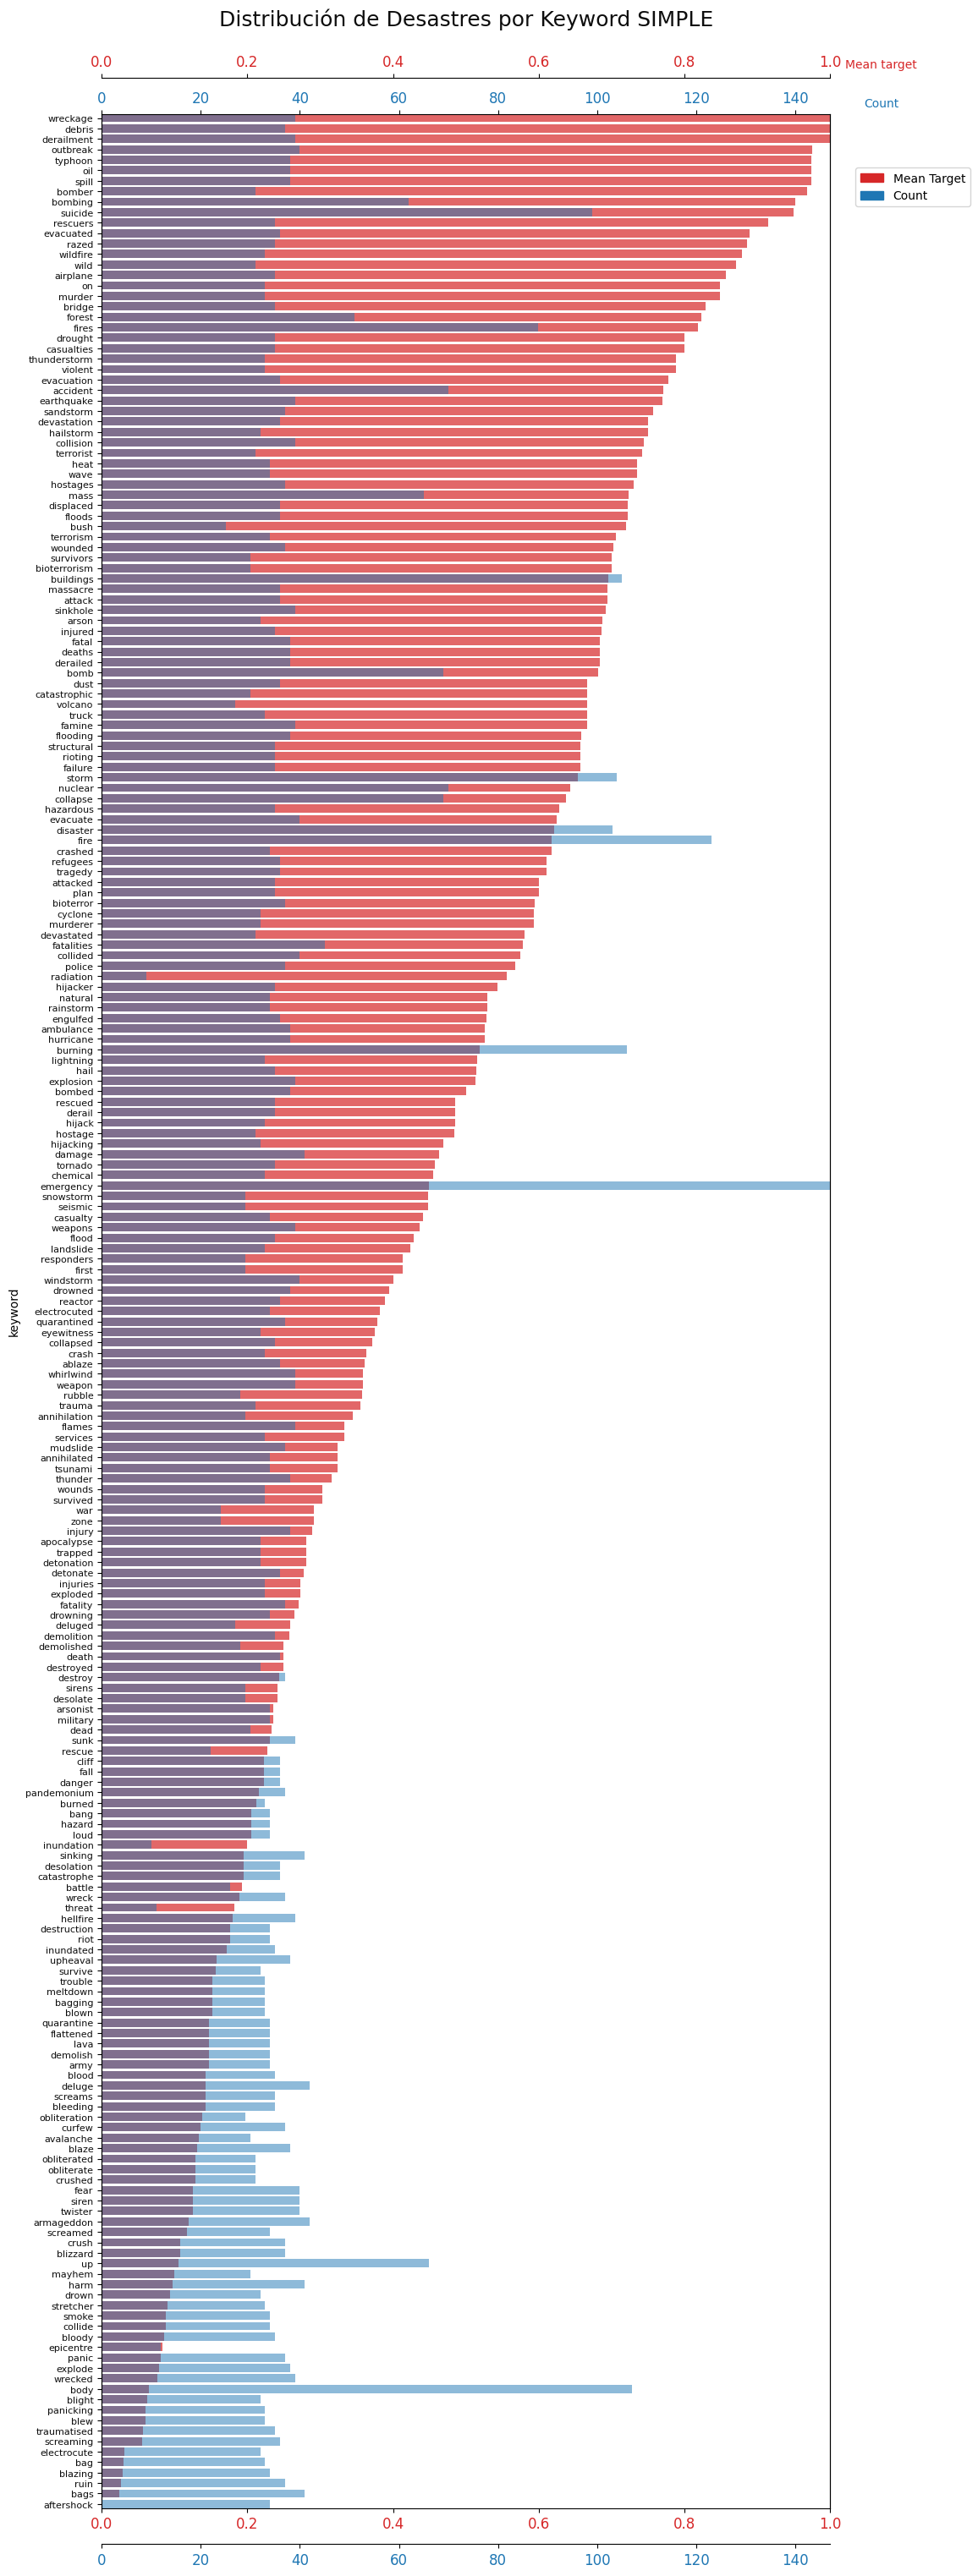

In [0]:
fig, ax1 = plt.subplots(figsize=(12, 30), dpi=100)

color = 'tab:red'
ax1.set_ylabel('keyword')
ax1.set_xlabel('Mean target', color=color)
ax1.barh(SKW_stats.index, width=SKW_stats[('target', 'mean')], height=0.8, color=color, alpha=0.7, label='Mean Target')

ax2 = ax1.twiny()  
color = 'tab:blue'
ax2.set_xlabel('Count', color=color)  
ax2.barh(SKW_stats.index, width=SKW_stats[('target', 'count')], height=0.8, color=color, alpha=0.5, label='Count')

ax1.margins(0, 0)
ax2.margins(0, 0)

import matplotlib.patches as mpatches
meanTarget_patch = mpatches.Patch(color='tab:red', label='Mean Target')
count_patch = mpatches.Patch(color='tab:blue', label='Count')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.98), handles=[meanTarget_patch, count_patch]) 

ax2.spines["bottom"].set_position(("axes", -0.015))
ax1.spines["top"].set_position(("axes", 1.015))
ax2.spines["bottom"].set_visible(True)
ax1.spines["top"].set_visible(True)
plt.title('Distribución de Desastres por Keyword SIMPLE', color=(0.05,0.05,0.05), pad=25, fontsize=18)
fig.tight_layout()
ax1.tick_params(axis='y', labelcolor= (0.05, 0.05, 0.05), labelsize=8)
ax1.tick_params(axis='x', labelcolor='tab:red', labelsize=12, labeltop=True, top=True, labelbottom=True, bottom=True)
ax2.tick_params(axis='x', labelcolor='tab:blue', labelsize=12, labeltop=True, top=True, labelbottom=True, bottom=True)
ax1.xaxis.set_label_coords(1.07, 1.023)
ax2.xaxis.set_label_coords(1.07, 1.003)
plt.show()

In [0]:
# Defino funcion para colorear palabras de wordcloud con un semaforo : Verde (1/3 < mean target), Amarillo (1/3 < mean target < 2/3), Rojo (2/3 < mean target)
def my_tf_color_func(dictionary):
  def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
    if dictionary[word] >= (2/3):
      return "rgb(255,0,0)"
    elif dictionary[word] >= (1/3):
      return "rgb(255,255,0)"
    return "rgb(0,255,0)"
  return my_tf_color_func_inner

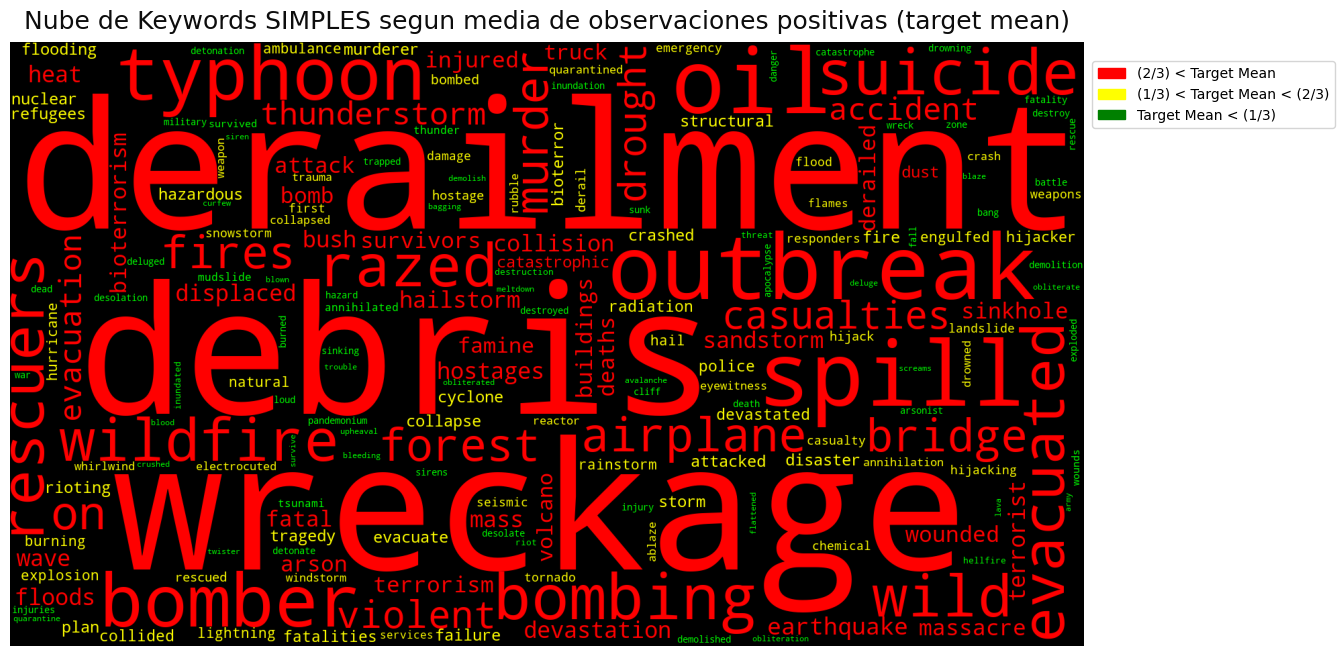

In [0]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=900, relative_scaling=1, font_step=1, color_func=my_tf_color_func(SKW_stats[('target', 'mean')]))
wordcloud.generate_from_frequencies(SKW_stats[('target', 'mean')])

fig = plt.figure(figsize=(20, 8), dpi=100)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nube de Keywords SIMPLES segun media de observaciones positivas (target mean)', color=(0.05,0.05,0.05), pad=10, fontsize=18)

red_patch = mpatches.Patch(color='red', label='(2/3) < Target Mean')
yellow_patch = mpatches.Patch(color='yellow', label='(1/3) < Target Mean < (2/3)')
green_patch = mpatches.Patch(color='green', label='Target Mean < (1/3)')
plt.legend(loc='upper right', bbox_to_anchor=(1.24, 0.98), handles=[red_patch, yellow_patch, green_patch]) 
plt.show()

In [0]:
KW_stats = df[['keyword', 'target']]
KW_stats.set_index('keyword')
KW_stats.dropna(inplace=True)
KW_stats = KW_stats.groupby(['keyword']).agg(['mean', 'count']).sort_values(by=('target', 'mean'), ascending=True)
KW_stats

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



target      
                 mean count
keyword                    
aftershock   0.000000    34
body%20bags  0.024390    41
ruin         0.027027    37
blazing      0.029412    34
body%20bag   0.030303    33
...               ...   ...
typhoon      0.973684    38
outbreak     0.975000    40
debris       1.000000    37
wreckage     1.000000    39
derailment   1.000000    39

[221 rows x 2 columns]

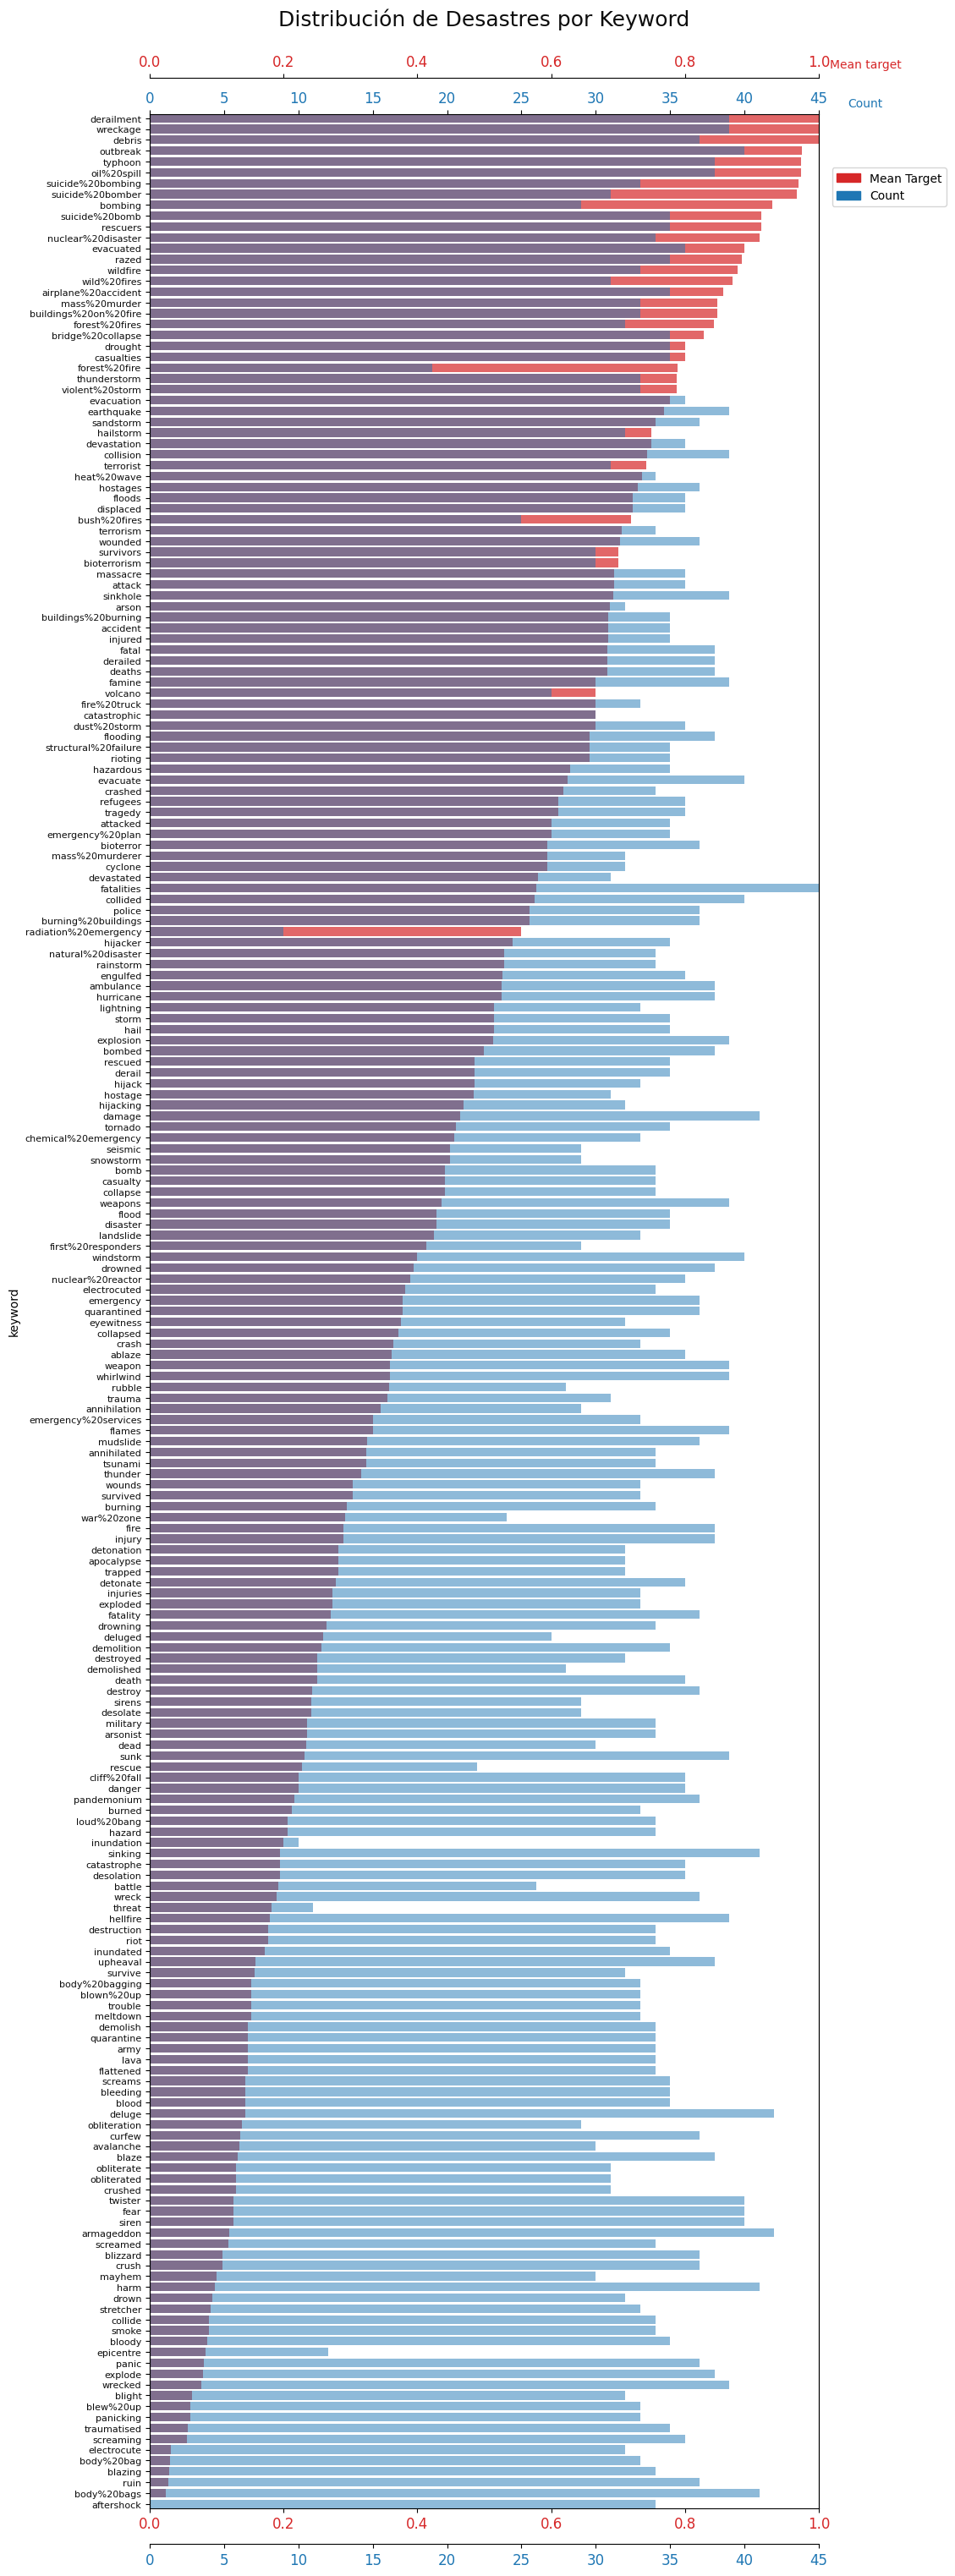

In [0]:
fig, ax1 = plt.subplots(figsize=(12, 30), dpi=100)

color = 'tab:red'
ax1.set_ylabel('keyword')
ax1.set_xlabel('Mean target', color=color)
ax1.barh(KW_stats.index, width=KW_stats[('target', 'mean')], height=0.8, color=color, alpha=0.7, label='Mean Target')

ax2 = ax1.twiny()  
color = 'tab:blue'
ax2.set_xlabel('Count', color=color)  
ax2.barh(KW_stats.index, width=KW_stats[('target', 'count')], height=0.8, color=color, alpha=0.5, label='Count')

ax1.margins(0, 0)
ax2.margins(0, 0)

import matplotlib.patches as mpatches
meanTarget_patch = mpatches.Patch(color='tab:red', label='Mean Target')
count_patch = mpatches.Patch(color='tab:blue', label='Count')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.98), handles=[meanTarget_patch, count_patch]) 

ax2.spines["bottom"].set_position(("axes", -0.015))
ax1.spines["top"].set_position(("axes", 1.015))
ax2.spines["bottom"].set_visible(True)
ax1.spines["top"].set_visible(True)
plt.title('Distribución de Desastres por Keyword', color=(0.05,0.05,0.05), pad=25, fontsize=18)
fig.tight_layout()
ax1.tick_params(axis='y', labelcolor= (0.05, 0.05, 0.05), labelsize=8)
ax1.tick_params(axis='x', labelcolor='tab:red', labelsize=12, labeltop=True, top=True, labelbottom=True, bottom=True)
ax2.tick_params(axis='x', labelcolor='tab:blue', labelsize=12, labeltop=True, top=True, labelbottom=True, bottom=True)
ax1.xaxis.set_label_coords(1.07, 1.023)
ax2.xaxis.set_label_coords(1.07, 1.003)
plt.show()

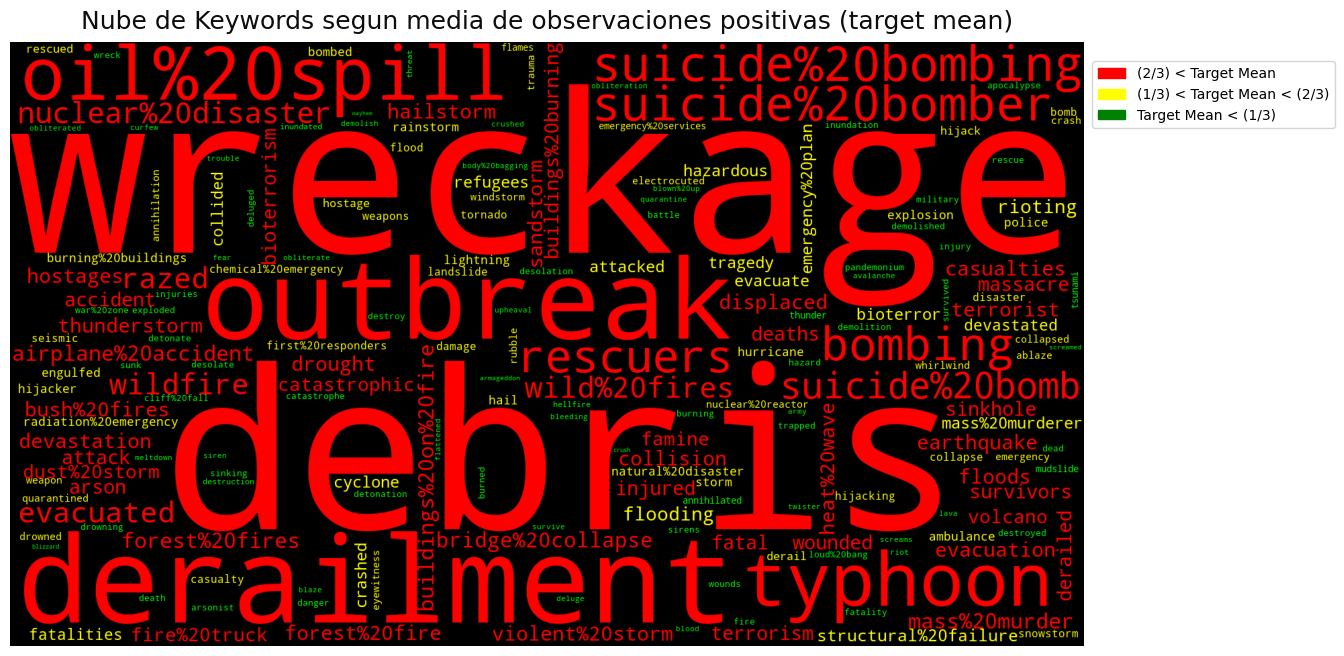

In [0]:
wordcloud = WordCloud(width=1600, height=900, relative_scaling=1, font_step=1, color_func=my_tf_color_func(KW_stats[('target', 'mean')]))
wordcloud.generate_from_frequencies(KW_stats[('target', 'mean')])

fig = plt.figure(figsize=(20, 8), dpi=100)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nube de Keywords segun media de observaciones positivas (target mean)', color=(0.05,0.05,0.05), pad=10, fontsize=18)

red_patch = mpatches.Patch(color='red', label='(2/3) < Target Mean')
yellow_patch = mpatches.Patch(color='yellow', label='(1/3) < Target Mean < (2/3)')
green_patch = mpatches.Patch(color='green', label='Target Mean < (1/3)')
plt.legend(loc='upper right', bbox_to_anchor=(1.24, 0.98), handles=[red_patch, yellow_patch, green_patch]) 
plt.show()

####target

In [0]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

0    57.377049
1    42.622951
Name: target, dtype: float64

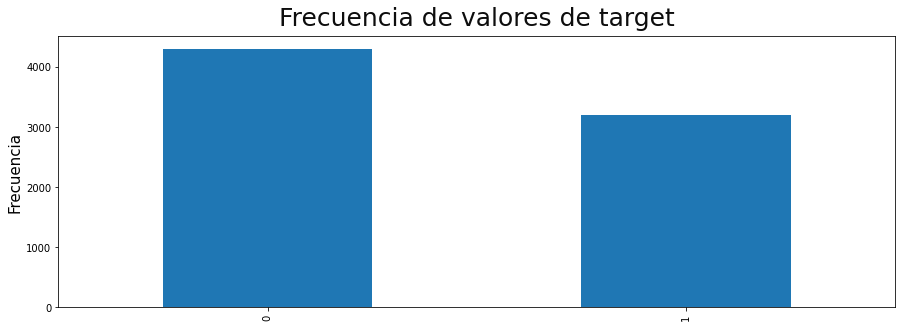

In [0]:

fig = df['target'].value_counts().sort_index().plot(kind='bar', figsize=(15,5)); # ver layout

fig.set_ylabel('Frecuencia', size=15)
plt.title('Frecuencia de valores de ''target''', color=(0.05,0.05,0.05), pad=10, fontsize=25)

df['target'].value_counts() /len(df)*100

Hay más no desastres que desastres.

Analizamos la relacion de la variable keyword con target en el siguiente gráfico.

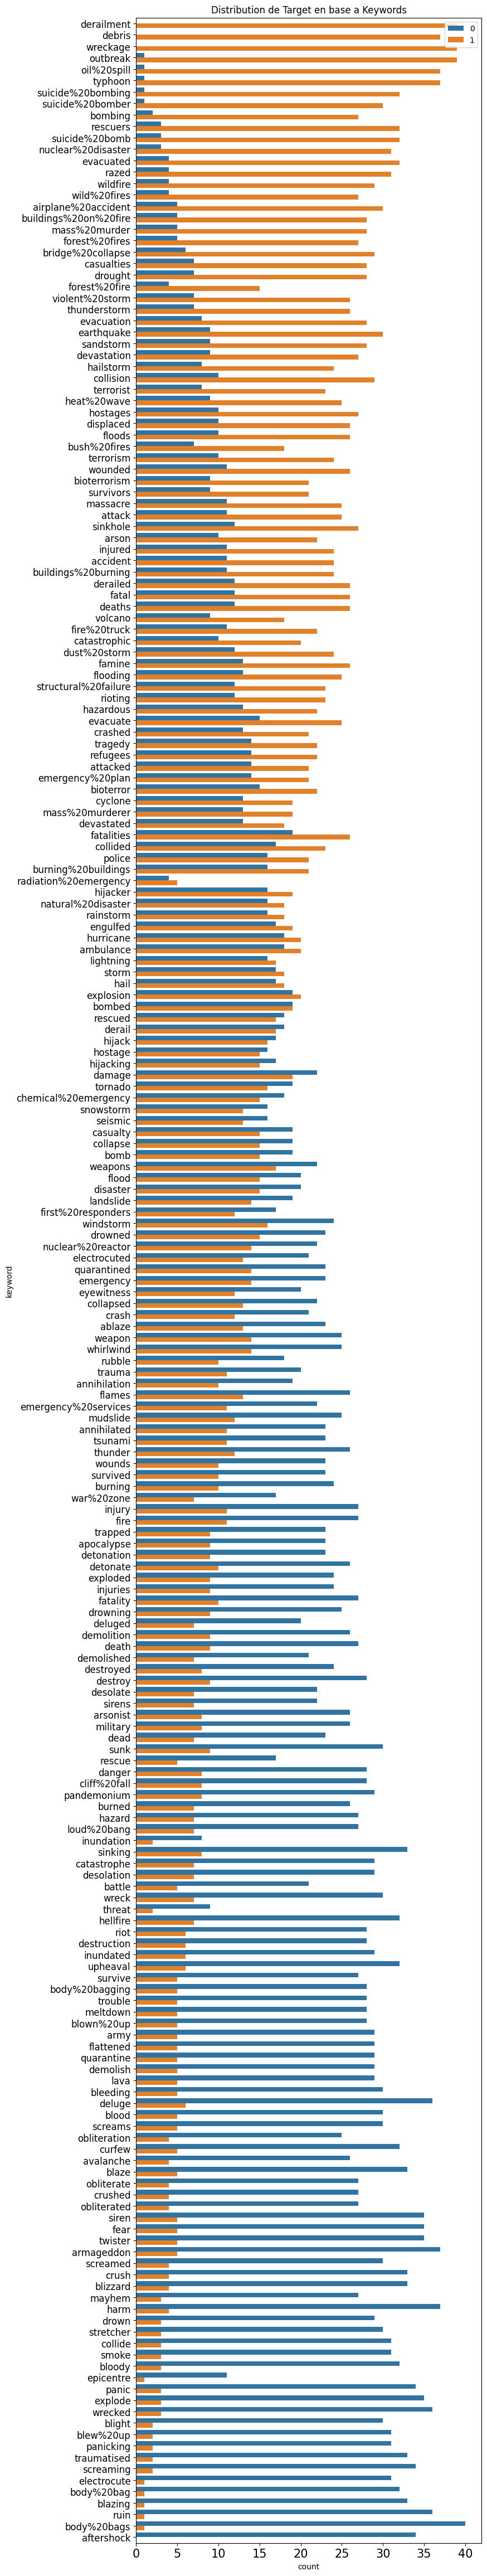

In [0]:
df['target_mean'] = df.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 60), dpi=100)

sns.countplot(y=df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Distribution de Target en base a Keywords')
plt.show()
df.drop(columns=['target_mean'], inplace=True)

Hay palabras como debris, wreckage, derailment son siempre desastres (target = 1). Mientras que aftershock no lo es (target = 0).

#### location

Se registraron tweets desde  3327 lugares.


Text(0.5, 1.0, 'Frecuencia de las locations')

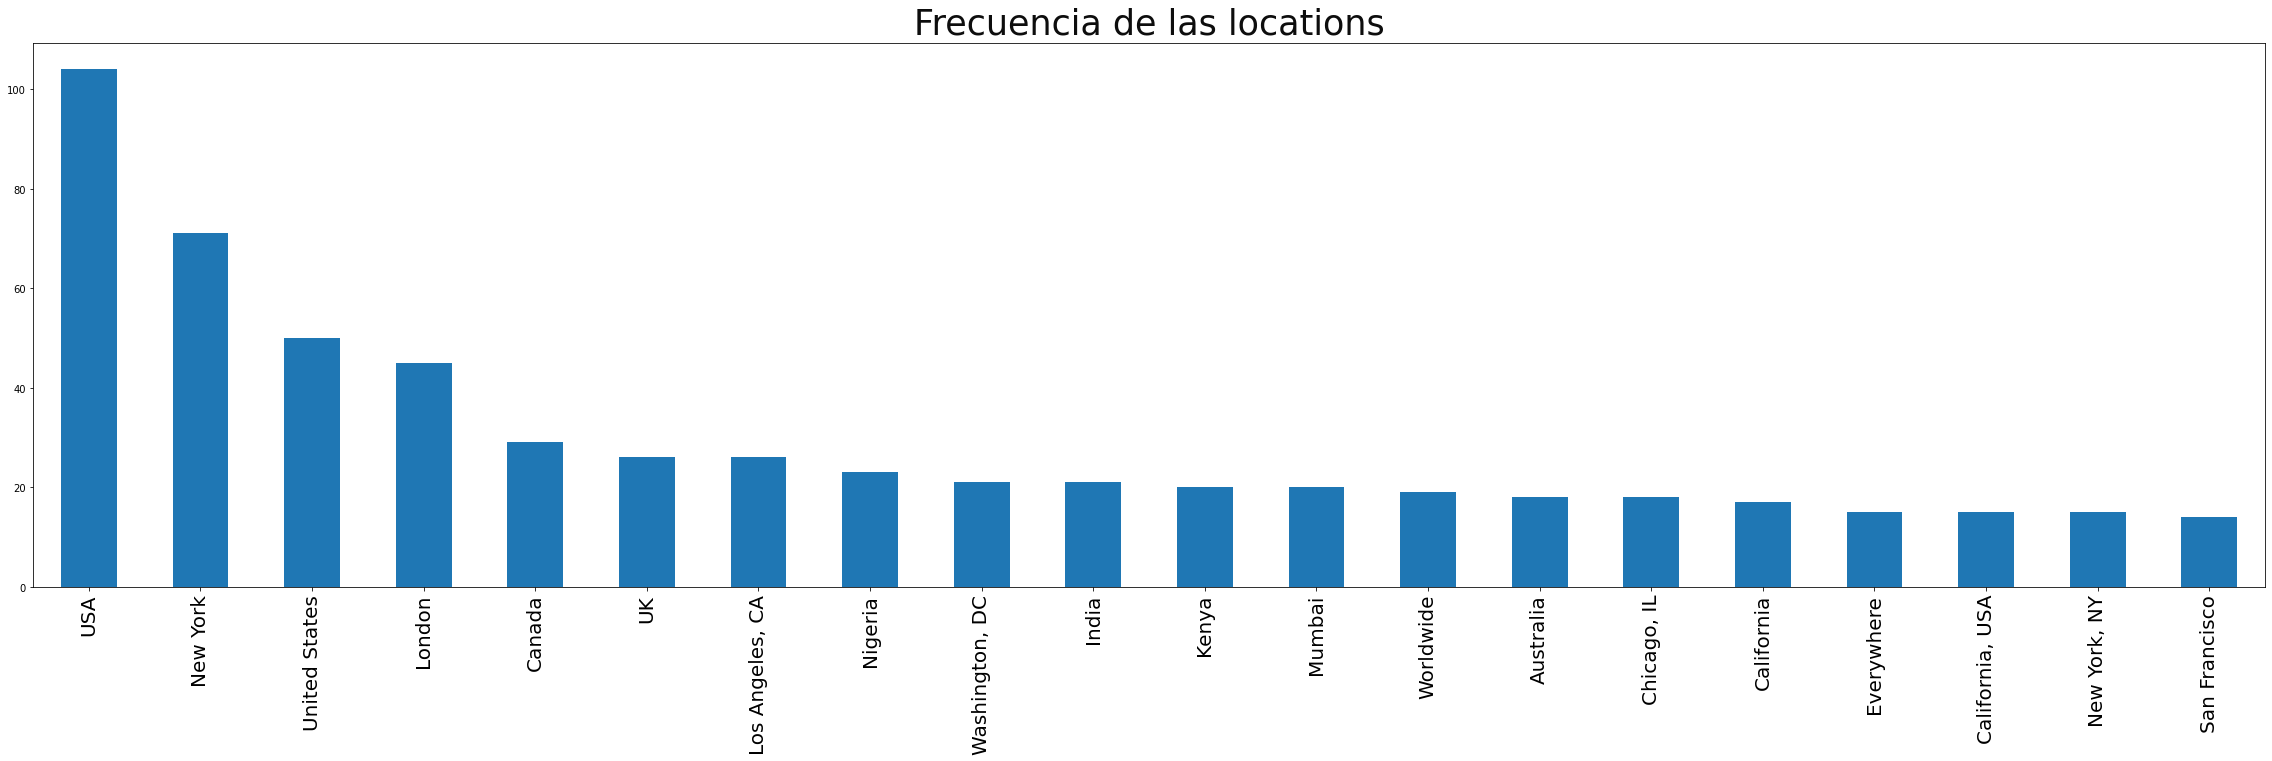

In [0]:
# histograma para identificar alguna/as locación particular
## plt configs
plt.figure(figsize=[40,10])
plt.xticks(fontsize=20, rotation=70)

df['location'].value_counts().head(20).plot(kind='bar')
print('Se registraron tweets desde ', df['location'].nunique(), 'lugares.')

fig.set_ylabel('Frecuencia', size=30)
plt.title('Frecuencia de las locations', color=(0.05,0.05,0.05), pad=10, fontsize=35)

No es correcto hablar de 3341 lugares distintos ya que dentro del listado de locaciones hay paises y estados, y mezclas de ambos. Incluso podemos ver a Estados Unidos escrito de dos maneras distintas y considerado como dos lugares distintos.
Ya que los estados figuran con su nombre y su código podríamos utilizar eso para facilmemnte asignarle a USA como pais.
Próximamente haremos otro tratamiento de las localidades.

Asimismo, podemos ver que la variable locations no esta automaticamente generada, sino que es un input que ingresa el usuario. Por este motivo, es que hay tantos "lugares distintos".

#####Mapa de locations

In [0]:
#!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

!pip install pyproj==1.9.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 0s (176 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1build2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 133.1MB 109kB/s 
     |████████████████████████████████| 10.9MB 2.3MB/s 
     |████████████████████████████████| 225kB 47.0MB/s 
  Created w

     |████████████████████████████████| 2.8MB 2.7MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp36-cp36m-linux_x86_64.whl size=3702117 sha256=5e46e44b9cf04a6719ae4a1a566ab5420cdc3b7ed9b843fb2dbb83f6f2436144
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
Successfully built pyproj
  Found existing installation: pyproj 2.6.1.post1
    Uninstalling pyproj-2.6.1.post1:
      Successfully uninstalled pyproj-2.6.1.post1


In [0]:
import folium
from folium import plugins
from geopy.geocoders import Nominatim

geolocator = Nominatim()

neg_locations = df[df.target==0]['location']
neg_locations.dropna(inplace=True)

pos_locations = df[df.target==1]['location']
pos_locations.dropna(inplace=True)



/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning:

Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
pos_longitude = []
pos_latitude = []

pos_unlocatedCount = 0
for location in pos_locations:#locationsCoord['location']:
        try:
          loc = geolocator.geocode(location)
        except:
          pos_unlocatedCount+=1
          print("Unlocated exception {}, count = {}".format(location, pos_unlocatedCount))
          continue
        if not loc:
            pos_unlocatedCount+=1
            print("Unlocated {}, count = {}".format(location, pos_unlocatedCount))
            continue
        pos_longitude.append(loc.longitude)
        pos_latitude.append(loc.latitude)

Unlocated Edmonton, Alberta - Treaty 6, count = 1
Unlocated Your Sister's Bedroom, count = 2
Unlocated Spain but Opa-Locka, FL, count = 3
Unlocated Financial News and Views, count = 4
Unlocated Somewhere Out There, count = 5
Unlocated Not a U.S resident, count = 6
Unlocated || c h i c a g o ||, count = 7
Unlocated Swaning Around, count = 8
Unlocated Wild Wild Web, count = 9
Unlocated CA physically- Boston Strong?, count = 10
Unlocated sindria, count = 11
Unlocated San Antonio-ish, TX, count = 12
Unlocated ÂÃÃÂÃÃÂÃÃ, count = 13
Unlocated exception New York, count = 14
Unlocated Online 24/7. Not even kidding., count = 15
Unlocated FIMAK A.S Ist Bolge Muduru, count = 16
Unlocated ??????????????????, count = 17
Unlocated SÃÂ£o Paulo SP,  Brasil, count = 18
Unlocated OES 4th Point. sisSTAR & TI, count = 19
Unlocated timeline kamu, count = 20
Unlocated Searching for Bae , count = 21
Unlocated exception Fresno, CA, count = 22
Unlocated Pig Symbol, Alabama, count = 23
Unlocated excep

In [0]:
neg_longitude = []
neg_latitude = []

neg_unlocatedCount = 0
for location in neg_locations:#locationsCoord['location']:
        try:
          loc = geolocator.geocode(location)
        except:
          neg_unlocatedCount+=1
          print("Unlocated exception {}, count = {}".format(location, neg_unlocatedCount))
          continue
        if not loc:
            neg_unlocatedCount+=1
            print("Unlocated {}, count = {}".format(location, neg_unlocatedCount))
            continue
        neg_longitude.append(loc.longitude)
        neg_latitude.append(loc.latitude)

Unlocated exception Est. September 2012 - Bristol, count = 1
Unlocated exception Philadelphia, PA, count = 2
Unlocated exception London, UK, count = 3
Unlocated exception Pretoria, count = 4
Unlocated exception Paranaque City, count = 5
Unlocated exception Live On Webcam, count = 6
Unlocated exception milky way, count = 7
Unlocated exception England., count = 8
Unlocated exception Barbados, count = 9
Unlocated exception Abuja, count = 10
Unlocated exception Sao Paulo, Brazil, count = 11
Unlocated exception hollywoodland , count = 12
Unlocated exception Inang Pamantasan, count = 13
Unlocated exception Twitter Lockout in progress, count = 14
Unlocated exception Calgary, AB, count = 15
Unlocated exception San Francisco, count = 16
Unlocated exception CLVLND, count = 17
Unlocated exception UK, count = 18
Unlocated exception St. Louis, MO, count = 19
Unlocated exception Norf Carolina, count = 20
Unlocated exception Baton Rouge, LA, count = 21
Unlocated exception Gloucestershire , UK, count 

In [0]:
fig = plt.figure(figsize=(8, 4))
m = folium.Map(width=1000, height=500, location=[0, 0],zoom_start=2)
m.add_child(plugins.HeatMap(zip(pos_latitude, pos_longitude), radius=8, min_opacity=10))
print('Densidad de tweets "Desastres" por ubicación (heatmap)')
m

Densidad de tweets "Desastres" por ubicación (heatmap)


<Figure size 576x288 with 0 Axes>

In [0]:
fig = plt.figure(figsize=(8, 4))
m = folium.Map(width=1000, height=500, location=[0, 0],zoom_start=2)
m.add_child(plugins.HeatMap(zip(neg_latitude, neg_longitude), radius=8, min_opacity=10))
print('Densidad de tweets "NO Desastres por ubicación (heatmap)')
m

Densidad de tweets "NO Desastres por ubicación (heatmap)


<Figure size 576x288 with 0 Axes>

####text

In [0]:
text = df['text']

In [0]:
len(text)

7613

In [0]:
len(text.unique())

7503

Habria 110 tweets repetidos. Es decir, considerando solamente el texto del tweet, vemos que hay 110 repetido. 
Combinaremos el texto con otras variables para terminar de decidir que duplicados eliminar de la base de datos.

Analizamos estas combinaciones anteriormente.

##### Ejemplos de tipos de observaciones

In [0]:

# ejemplos de observaciones positivas (target=1)
print(df.text.loc[0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


In [0]:
print(df.target.loc[0])

1


In [0]:
df[df.target==1].sample(5)

,id,keyword,location,text,target
3891,5532,flattened,Leeds,Flattened thee striker,1
1335,1929,burning%20buildings,NaN,@fewmoretweets all lives matter. Just not a fa...,1
7027,10072,typhoon,NaN,Typhoon Soudelor: When will it hit Taiwan ÂÃ...,1
6442,9217,suicide%20bombing,NaN,&lt; Suicide Bombing Of European Union Car Kil...,1
2878,4138,drought,Philadelphia,California meets drought-fueled fire season wi...,1


In [0]:
# ejemplos de observaciones negativas (target=0)
df[df.target==0].sample(5)

,id,keyword,location,text,target
1305,1886,burning,NaN,@JohnsonTionne except idk them?? it's really b...,0
388,561,arson,"Kingston, Pennsylvania",The Sound of Arson,0
1034,1500,body%20bags,"WAISTDEEP, TX",@Deeeznvtzzz bring the body bags tho,0
6215,8866,smoke,WORLDWI$E,I smoke toooooo much lmao I was scared to text...,0
1048,1515,body%20bags,In the Shadows...,@Limpar33 sweeping legs? Or putting people in ...,0


In [0]:
print(df.text.loc[7479])

@_PokemonCards_ @IceQueenFroslas why did they have to wreck it with ON SALE HERE ;-;


In [0]:
print(df.target.loc[7479])

0


##### Análisis de frecuencias de palabras

Procederemos con un análisis más detallado del texto de los tweets.
Analizaremos las frecuencias de las palabras en en general, y como se distribuyen en los dos tipos de tweets.

Como primer paso eliminaremos aquellas palabras que se repiten mucho porque se utilizan cómo conectores, se las denomina STOPWORDS. Tambíen eliminaremos los símbolos y algunas construcciones que no aportan nigún significado y que son frecuentes en la escritura informal.

In [0]:
# import de stopwords para depurar los tweets
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# filtro las stop words
every_tweet_text = ''.join(df['text'])
every_tweet_text_words = nltk.word_tokenize(every_tweet_text)

stop_words = list(set(nltk.corpus.stopwords.words("english")))

tweets_without_stop_words = []
tweets_stopwords = []

for word in every_tweet_text_words:
    if word.lower() in stop_words:
        tweets_stopwords.append(word)
    else:
        tweets_without_stop_words.append(word)

# las palabras  más repetidas
tweet_word_freq = Counter(tweets_without_stop_words)

print('The ten most common words are:')
tweet_word_freq.most_common(20)

The ten most common words are:


[(':', 6608),
 ('http', 4225),
 ('#', 3312),
 ('?', 3109),
 ('@', 2740),
 ('.', 2369),
 ('!', 1159),
 ('...', 1033),
 ('-', 772),
 ("'s", 771),
 ("'", 612),
 (';', 573),
 ('&', 455),
 ("n't", 439),
 ('https', 403),
 (')', 362),
 ('amp', 342),
 ('(', 338),
 ('like', 314),
 ("'m", 236)]

In [0]:
# Append de las palabras más comunes y símbolos al listado de stop words
print('# of stopwords:',len(stop_words))

most_common_words = [word for word, count  in tweet_word_freq.most_common(20)]
symobls = [i for i in '! " # $ % & ( ) * + , - . / : ; < = > ? @ [ \ \ ] ^ _ ` { | } ~ \ t\ '.split()]
extra_stop_words = most_common_words + symobls

stop_words = stop_words + extra_stop_words

print('# of stopwords:',len(stop_words))

# of stopwords: 179
# of stopwords: 233


In [0]:
# filtro las stop words nuevamente y las URLs
every_tweet_text = ''.join(df['text'])
every_tweet_text_words = nltk.word_tokenize(every_tweet_text)

tweets_without_stop_words = []
tweets_with_stopwords = []

for word in every_tweet_text_words:
    if (word.lower() in stop_words) | (word.isnumeric()) | ('//t.co' in word.lower()):
        tweets_with_stopwords.append(word)
    else:
        tweets_without_stop_words.append(word)
        
tweets_without_stop_words_freq = Counter(tweets_without_stop_words)

        
print('Las palabras más comunes son:')
tweets_without_stop_words_freq.most_common(20)

Las palabras más comunes son:


[('via', 208),
 ('get', 184),
 ('fire', 160),
 ('people', 157),
 ('one', 153),
 ('would', 126),
 ("'re", 123),
 ('got', 111),
 ('new', 103),
 ('know', 102),
 ('California', 101),
 ('video', 95),
 ('back', 94),
 ('going', 92),
 ('News', 91),
 ('killed', 90),
 ('disaster', 89),
 ('gt', 88),
 ('still', 88),
 ('see', 87)]

El análsis de frecuencias, además de saciar la curiosidad, es útil para intentar tener una mirada rápida de lo que trata el total del texto. En este caso, al ser tweets, las temáticas soon muy variadas y es dificil encontrar y destinguir tematicas, por lo que la clasificación de si pertenece un tweet de un evento trágico o no resulta un buen punto de partida. En este contexto, repetiremos el procedimiento anterior, pero esta vez diferenciando las que más se repiten en cada uno de los dos grupos. El objetivo de esto es ver si las palabras más frecuentes nos aportan algúna información, algúna estructura o algún patrón propio del grupo al que pertenecen.

In [0]:
## tragic tweets
tragic_tweets = df[df['target'] == 1]
tragic_tweets_text = ''.join(tragic_tweets['text'])
tragic_tweets_text_words = nltk.word_tokenize(tragic_tweets_text)


tragic_tweets_without_stop_words = []
tragic_tweets_with_stopwords = []

for word in tragic_tweets_text_words:
    if (word.lower() in stop_words) | (word.isnumeric()) | ('//t.co' in word.lower()):
      tragic_tweets_with_stopwords.append(word)
    else:
        tragic_tweets_without_stop_words.append(word)
        
tragic_tweets_word_freq = Counter(tragic_tweets_without_stop_words)

print('Las más comunes para los tweets trágicos:')
tragic_tweets_word_freq.most_common(20)

Las más comunes para los tweets trágicos:


[('fire', 118),
 ('via', 116),
 ('California', 94),
 ('people', 87),
 ('killed', 87),
 ('News', 75),
 ('Hiroshima', 73),
 ('suicide', 67),
 ('disaster', 66),
 ('crash', 66),
 ('fires', 66),
 ('MH370', 62),
 ('buildings', 60),
 ('police', 58),
 ('Northern', 57),
 ('train', 56),
 ('bombing', 56),
 ('Legionnaires', 56),
 ('one', 55),
 ('bomb', 54)]

In [0]:
## not tragic tweets
not_tragic_tweets = df[df['target'] == 0]
not_tragic_tweets_text = ''.join(not_tragic_tweets['text'])
not_tragic_tweets_text_words = nltk.word_tokenize(not_tragic_tweets_text)


not_tragic_tweets_without_stop_words = []
not_tragic_tweets_with_stopwords = []

for word in not_tragic_tweets_text_words:
    if (word.lower() in stop_words) | (word.isnumeric()) | ('//t.co' in word.lower()):
        not_tragic_tweets_with_stopwords.append(word)
    else:
        not_tragic_tweets_without_stop_words.append(word)
        
not_tragic_tweets_word_freq = Counter(not_tragic_tweets_without_stop_words)

print('Las más comunes para los tweets no-trágicos:')
not_tragic_tweets_word_freq.most_common(20)

Las más comunes para los tweets no-trágicos:


[('get', 143),
 ('one', 98),
 ('would', 92),
 ('via', 92),
 ("'re", 86),
 ('new', 84),
 ('got', 82),
 ('know', 76),
 ('people', 71),
 ('see', 68),
 ('going', 68),
 ('back', 68),
 ('Full', 68),
 ('gt', 67),
 ('body', 67),
 ('time', 63),
 ('video', 63),
 ('still', 62),
 ('YouTube', 62),
 ('day', 60)]

No se llega a identifcar una temática en particular pero si se observa como los tweets durante un evento trágico son, de una forma, más precisos. Por más precisos entendemos a que encontramos para nombres propios, sustantivos y verbos específicos. Por el otro lado, los tweets en momentos nos trágicos, parecieran contener palabras más coloquiales, propias de la actividad propia de tweetear contenidos diverso.

Text(-20, 40, 'Estas son las palabras más freceuntes en común')

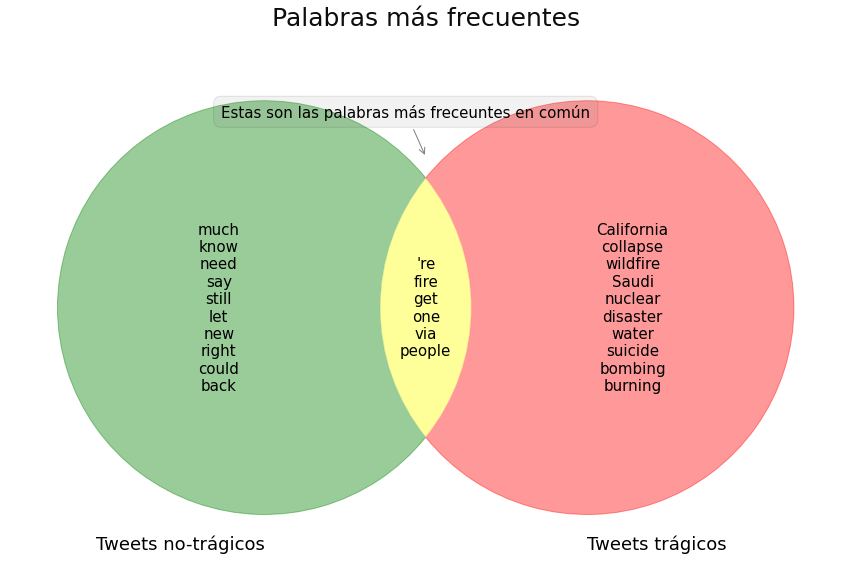

In [0]:
B = set([word for word, count in not_tragic_tweets_word_freq.most_common(50)])
A = set([word for word, count in tragic_tweets_word_freq.most_common(50)])

plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 15})

v = venn2([B,A], ('Tweets no-trágicos', 'Tweets trágicos'))

v.get_label_by_id('10').set_text('\n'.join(list(B-A)[:10]))
v.get_label_by_id('11').set_text('\n'.join(list(A&B)[:10]))
v.get_label_by_id('01').set_text('\n'.join(list(A-B)[:10]))

#plt.rcParams.update({'font.size': 15})
plt.title('Palabras más frecuentes', color=(0.05,0.05,0.05), pad=25, fontsize=25)

v.get_patch_by_id('01').set_color('red')
v.get_patch_by_id('01').set_alpha(0.4)

v.get_patch_by_id('10').set_color('green')
v.get_patch_by_id('10').set_alpha(0.4)


v.get_patch_by_id('11').set_color('yellow')
v.get_patch_by_id('11').set_edgecolor('white')
v.get_patch_by_id('11').set_alpha(0.4)


plt.annotate('Estas son las palabras más freceuntes en común', xy=v.get_label_by_id('11').get_position() +
             np.array([0, 0.3]), xytext=(-20,40), ha='center',
             textcoords='offset points', 
             bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->',              
                            connectionstyle='arc',color='gray',))
                            

Dado que las palabaras pueden tener varios significados según el contexto en el que se utilizan, una práctica casi obligatoria es la de analizar la frecuencia de los n-gramas, es decir, los pares de n palabras. De esta forma, se puede llegara encontrar alguna nocón de idea o concepto y no una simple palabra.
Aquí se ven bi-gramas (dos palabras) y tri-gramas (tres palabras). Recordemos que se han quitado las stopwords, por lo que las parejas pueden resultar inconexas.

In [0]:
# armado de listado de palabrás que estan presentes unicamente en los tweets trágicos

not_tragic_words = [nt_word for nt_word, nt_count in not_tragic_tweets_word_freq.items()]
tragic_words = [t_word for t_word, t_count in tragic_tweets_word_freq.items()]

not_unique_tragic_words = [word for word in tragic_words if word in not_tragic_words]
not_unique_tragic_words

for word in not_unique_tragic_words:
    tragic_tweets_word_freq.pop(word)
unique_tragic_tweets_word_freq = tragic_tweets_word_freq


print('Palbaras que están presentes en tweets trágicos, únicamente:')
unique_tragic_tweets_word_freq.most_common(10)

Palbaras que están presentes en tweets trágicos, únicamente:


[('MH370', 62),
 ('Northern', 57),
 ('Legionnaires', 56),
 ('bomber', 50),
 ('wildfire', 40),
 ('debris', 36),
 ('outbreak', 34),
 ('migrants', 33),
 ('mosque', 29),
 ('Atomic', 29)]

In [0]:
# comparison on words between tragic and not_tragic tweeta, and update of the counter with the unique
# words for tragic tweet

not_tragic_words = [nt_word for nt_word, nt_count in not_tragic_tweets_word_freq.items()]
tragic_words = [t_word for t_word, t_count in tragic_tweets_word_freq.items()]

not_unique_not_tragic_words = [word for word in not_tragic_words if word in tragic_words]


for word in not_unique_not_tragic_words:
    not_tragic_tweets_word_freq.pop(word)
unique_not_tragic_tweets_word_freq = not_tragic_tweets_word_freq


print('Palbaras que están presentes en tweets trágicos, únicamente:')
unique_not_tragic_tweets_word_freq.most_common(10)

Palbaras que están presentes en tweets trágicos, únicamente:


[('get', 143),
 ('one', 98),
 ('would', 92),
 ('via', 92),
 ("'re", 86),
 ('new', 84),
 ('got', 82),
 ('know', 76),
 ('people', 71),
 ('see', 68)]

In [0]:
from nltk.util import ngrams

## tragic reviews
# building of the bi-grams
Counter(list(ngrams(tragic_tweets_without_stop_words, 2))).most_common(20)

[(('Northern', 'California'), 37),
 (('suicide', 'bomber'), 32),
 (('oil', 'spill'), 29),
 (('suicide', 'bombing'), 27),
 (('sue', 'Legionnaires'), 25),
 (('families', 'affected'), 25),
 (('affected', 'fatal'), 25),
 (('fatal', 'outbreak'), 25),
 (('bomber', 'detonated'), 25),
 (('burning', 'buildings'), 24),
 (('MH370', 'Malaysia'), 24),
 (('Legionnaires', 'families'), 24),
 (('outbreak', 'Legionnaires'), 24),
 (('Airport', 'Get'), 24),
 (('Get', 'Swallowed'), 24),
 (('Swallowed', 'Sandstorm'), 24),
 (('Sandstorm', 'Minute'), 24),
 (('PKK', 'suicide'), 23),
 (('detonated', 'bomb'), 23),
 (('spill', 'may'), 22)]

Text(-20, 40, 'Estos son los bigramas más frecuentes en ambos conjuntos')

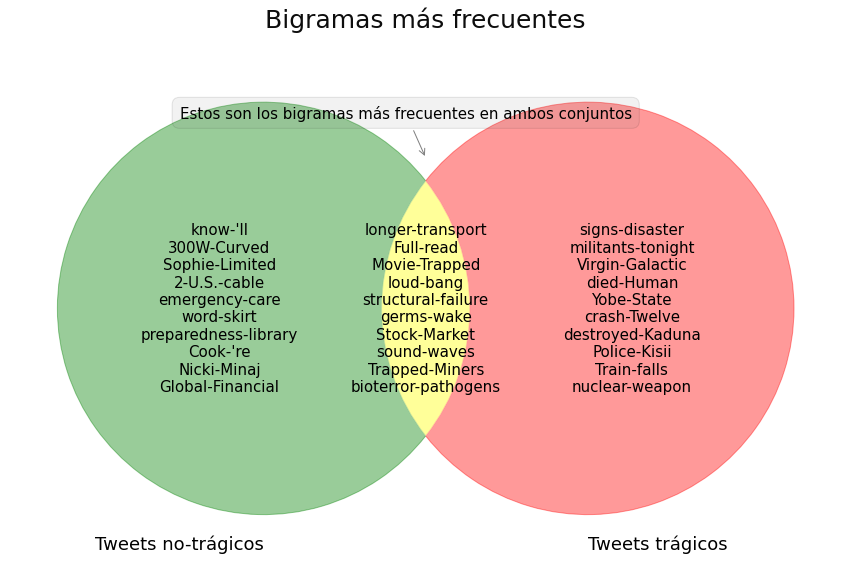

In [0]:
C = set([word[0]+'-'+word[1] for word, count in Counter(list(ngrams(tragic_tweets_without_stop_words, 2))).most_common(1000)])
D = set([word[0]+'-'+word[1] for word, count in Counter(list(ngrams(not_tragic_tweets_without_stop_words, 2))).most_common(1000)])

plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 15})

v = venn2([D,C], ('Tweets no-trágicos', 'Tweets trágicos'))

v.get_label_by_id('10').set_text('\n'.join(list(D-C)[:10]))
v.get_label_by_id('11').set_text('\n'.join(list(C&D)[:10]))
v.get_label_by_id('01').set_text('\n'.join(list(C-D)[:10]))

#plt.rcParams.update({'font.size': 15})
plt.title('Bigramas más frecuentes', color=(0.05,0.05,0.05), pad=25, fontsize=25)

v.get_patch_by_id('01').set_color('red')
v.get_patch_by_id('01').set_alpha(0.4)

v.get_patch_by_id('10').set_color('green')
v.get_patch_by_id('10').set_alpha(0.4)


v.get_patch_by_id('11').set_color('yellow')
v.get_patch_by_id('11').set_edgecolor('white')
v.get_patch_by_id('11').set_alpha(0.4)


plt.annotate('Estos son los bigramas más frecuentes en ambos conjuntos', xy=v.get_label_by_id('11').get_position() +
             np.array([0, 0.3]), xytext=(-20,40), ha='center',
             textcoords='offset points', 
             bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->',              
                            connectionstyle='arc',color='gray',))
                            

Por último, procederemos con el análisis morfológico de los textos, conservando la división entre trágicos y no trágicos. A priori, es poco el valor que pueda llegar a aportar a esta altura esta caracterización, pero es un grado más de precisíon que le damos al conteo que puede ayudar a visualizar más detalladamente el tipo de conceptos y estructuras que hay detras de los tweets de cada grupo.

In [0]:

# análisis morflógico
tragic_tweets_tags = nltk.pos_tag(tragic_tweets_without_stop_words)

## sustantivos
unique_tragic_tweets_nouns = set([(word, tag) for word, tag in tragic_tweets_tags if ('NN' in tag)])
for word in tragic_tweets_text_words:
    if (word.lower() in unique_tragic_tweets_nouns):
        tragic_tweets_nouns.append(word)
tragic_tweets_nouns_freq = Counter(tragic_tweets_nouns)

print('The ten most common nouns in tragic tweets are:')
tragic_tweets_nouns_freq.most_common(20)

LookupError: ignored

In [0]:
## adjetvios y adverbios
unique_tragic_tweets_adv_adj = set([(word, tag) for word, tag in tragic_tweets_tags if ('JJ' in tag) |('RB' in tag)])
for word in tragic_tweets_text_words:
    if (word.lower() in unique_tragic_tweets_adv_adj):
        tragic_tweets_adv_adj.append(word)
tragic_tweets_adv_adj_freq = Counter(tragic_tweets_adv_adj)

print('The ten most common adjectives and adverbs in tragic tweets are:')
tragic_tweets_adv_adj_freq.most_common(20)

NameError: ignored

In [0]:
## verbos
unique_tragic_tweets_verbs = set([(word, tag) for word, tag in tragic_tweets_tags if ('VB' in tag)])
for word in tragic_tweets_text_words:
    if (word.lower() in unique_tragic_tweets_verbs):
        tragic_tweets_verbs.append(word)
tragic_tweets_verbs_freq = Counter(tragic_tweets_verbs)

print('The ten most common nouns in tragic tweets are:')
tragic_tweets_verbs_freq.most_common(20)

NameError: ignored

##### Create Pos / Neg Dataframes

In [0]:
pos=df[df.target==1]
neg=df[df.target==0]

##### Word Cloud de stop words (?)

In [0]:
!pip install wordcloud

In [0]:
pos.head()

In [0]:
pos.head(10)

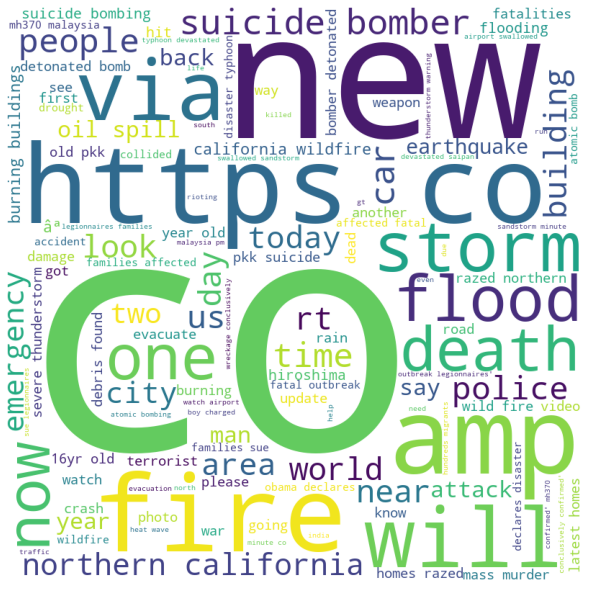

In [0]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  

all_words=[]
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in pos.text: 
  
    # split tweet into words 
    tokens = val.split() 
    #print(tokens)
    
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
    all_words.extend(tokens)
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

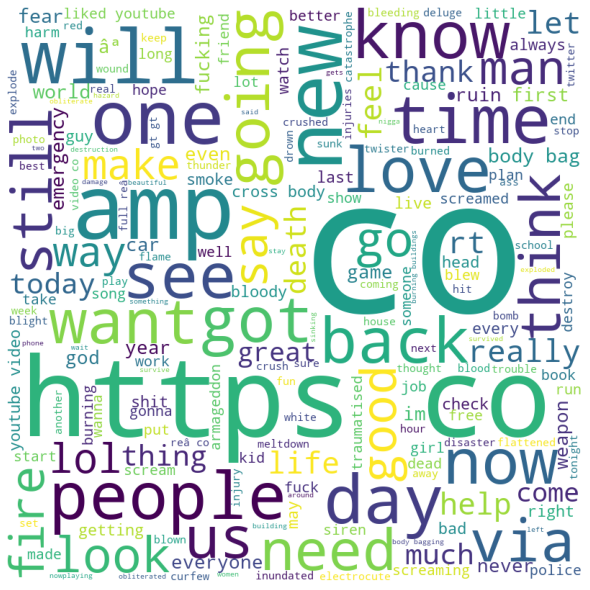

In [0]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  

all_words=[]
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in neg.text: 
  
    # split tweet into words 
    tokens = val.split() 
    #print(tokens)
    
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
    all_words.extend(tokens)
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Word Cloud de Keywords simples

In [0]:
SingleKeywords = train2_df['keyword'].str.split('%20', expand=True)


In [0]:
# Defino funcion para colorear palabras de wordcloud con un semaforo : Verde (1/3 < mean target), Amarillo (1/3 < mean target < 2/3), Rojo (2/3 < mean target)
def my_tf_color_func(dictionary):
  def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
    if dictionary[word] >= (2/3):
      return "rgb(255,0,0)"
    elif dictionary[word] >= (1/3):
      return "rgb(255,255,0)"
    return "rgb(0,255,0)"
  return my_tf_color_func_inner

In [0]:
from matplotlib import cm

#wordcloud.generate_from_frequencies({'hola': 10, 'pepe': 5})
d = {}
for index, row in keywordMeanTarget.iterrows():
    d[index] = row[0]#int(100 * row[0])

wordcloud = WordCloud(width=1600, height=900, relative_scaling=1, font_step=1, color_func=my_tf_color_func(d))#colormap=cm.inferno)
wordcloud.generate_from_frequencies(d)

fig = plt.figure(figsize=(20, 8), dpi=100)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

NameError: ignored

##### Metas

Puede ser que los desaster tweets (target = 1) esten escritos de manera mas "formal" o completa que los no disaster (target = 0). Analisamos las siguientes caracteristicas:



In [0]:
#punctuation_count number of punctuations in text - NO


*  word_count numero de palabras en text
*  unique_word_count numero unico de palabras en text
*  stop_word_count numero de stop words (conjunciones, conectores, etc) en text
*  url_count numero de urls en text
*  mean_word_length promedio de caracteres en palabras
*  char_count numero de caracteres en text
*  hashtag_count numero de hashtags (#) en text
*  mention_count numero de arrobas (@) en text

In [0]:
# word_count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))
test_df['unique_word_count'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

# url_count
df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_df['url_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

In [0]:
# mean_word_length
df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['text'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['text'].apply(lambda x: len(str(x)))



In [0]:
# hashtag_count
df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df['mention_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [0]:
#no la hice
# punctuation_count
df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['punctuation_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))


NameError: ignored

All of the meta features have very similar distributions in training and test set which also proves that training and test set are taken from the same sample.

All of the meta features have information about target as well, but some of them are not good enough such as url_count, hashtag_count and mention_count.

On the other hand, word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count have very different distributions for disaster and non-disaster tweets. Those features might be useful in models...

In [0]:
#'punctuation_count'
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_df[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [0]:
# Se puede observar que a pesar de haber tweets más largos en caso de desaastre, el promedio de palabras parece conservarse.
# Es probable que sea "gritando" via texto.


In [0]:
# se observa una longitud mayor en los tweets asociados a un desastre


##### Violin chart ?

sobre disaster non disaster and longitud del texto en caracteres.

Text(0, 0.5, 'Cantidad de caracteres')

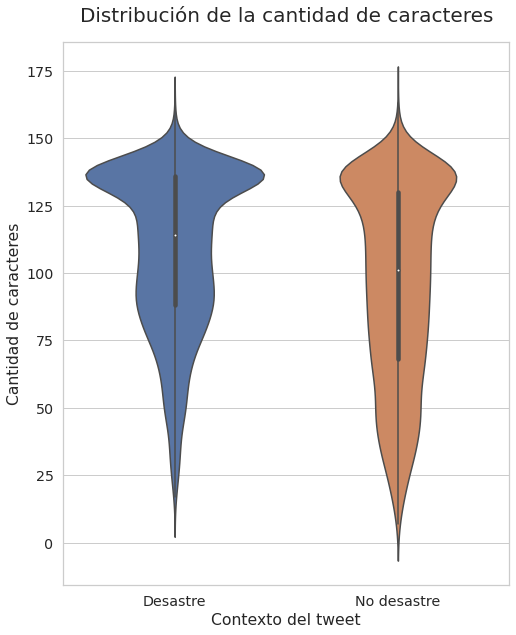

In [0]:
# acomodo el df para el la viz
df['target'].replace({1:'Desastre', 0:'No desastre'}, inplace=True)

# se observa una longitud mayor en los tweets asociados a un desastre
plt.figure(figsize=[8,10])
sns.set(style="whitegrid", palette="deep", color_codes=True, font_scale=1.3)

fig = sns.violinplot(y="char_count", x='target', data=df)
fig.set_title('Distribución de la cantidad de caracteres', pad=20.0, fontdict={'fontsize':20})
fig.set_xlabel('Contexto del tweet')
fig.set_ylabel('Cantidad de caracteres')